In [3]:
import sys
# print(sys.executable)
!pip install torch torchvision torchaudio

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
from tqdm import tqdm

running_in_colab = 'google.colab' in str(get_ipython())

if running_in_colab == True:
    drive.mount('/content/gdrive/')
    GOOGLE_DRIVE_PATH_AFTER_GDRIVE = '#####YOUR PATH HERE####### '
    GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_GDRIVE)
    os.chdir(os.path.join('/content',GOOGLE_DRIVE_PATH))
else:
    GOOGLE_DRIVE_PATH = os.path.join('C:\\Users\\sarah\\OneDrive\\Desktop\\rob599-3D_perception\\point_clouds')
    os.chdir(os.path.join('/content',GOOGLE_DRIVE_PATH))

print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

C:\Users\sarah\OneDrive\Desktop\rob599-3D_perception\point_clouds
['.ipynb_checkpoints', 'data', 'Homework2.ipynb']


# Instructions:
Download the data from this [link](https://colab.research.google.com/drive/16Q3M_H6L1l_y2xu2MQP6icj6iN75zu18?usp=sharing). Unzip and upload it to your google drive in a folder called ```Homework2```. Make sure all files are stored in a folder called ```data``` inside the folder ```Homework2```. Copy the path after ```gdrive/``` to folder ```Homework2``` and paste it in the space above.

## Q1a. Getting a point cloud from a Depth image

You are given a rgb image, a depth image and a mask. Your task is to generate point cloud data from the given depth image and the corresponding colour from the RGB image. Recall we used projection equations to project 3D points to a 2D plane. Here, given depth, we need to reproject the points back onto a 3D plane. You are also given the camera data (focal length and camera center). Use the data from file ```generate_point_cloud.npz```

```CORRECTION: The pricipal points are not given in the file. Here are the values for the principal point: 0.4224, -0.0300```

![](https://drive.google.com/uc?export=view&id=1Dng54OFGump4H5-m7BLpgoL3ikMLa7aP)


In [5]:
def generate_point_clouds(rgb_image, depth_image, mask, camera_data):
    """
    Generate a 3D point cloud from a given RGB image, depth image, and mask using camera data.

    Args:
        rgb_image (numpy.ndarray): RGB image as a NumPy array.
        depth_image (numpy.ndarray): Depth image as a NumPy array.
        mask (numpy.ndarray): Binary mask indicating valid pixels in the images.
        camera_data (dict): Camera parameters including focal length and camera center.

    Returns:
        point_cloud (numpy.ndarray): 3D point cloud represented as a NumPy array of shape (N, 3),
            where N is the number of valid points.
        rgb (numpy.ndarray): RGB color values corresponding to the 3D points, represented as a
            NumPy array of shape (N, 3), where N is the number of valid points.
    """
    focal_length = camera_data["focal_length"]
    print('focal', np.shape(focal_length))
    print(focal_length[0, 0])
    camera_center = camera_data["camera_center"]
    print('size rgb', np.shape(rgb_image))
    print('size depth', np.shape(depth_image))
    print('size mask', np.shape(mask))

    height, width = np.shape(depth_image)
    num_pixels = height * width
    N = num_pixels - np.sum(mask == 0)
    point_cloud = np.zeros((N, 3))
    rgb = np.zeros((N, 3))

    rgb_image = rgb_image.reshape((num_pixels, 3))
    depth_image = depth_image.reshape((num_pixels))
    mask = mask.reshape((num_pixels))
    print('size rgb', np.shape(rgb_image))
    print('size depth', np.shape(depth_image))
    print('size mask', np.shape(mask))

    # projection matrix
    M = np.array([[focal_length[0, 0], 0, 0.4224], [0, focal_length[0, 1], -0.03], [0, 0, 1]]) @ \
        np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    M_pinv = M.T @ np.inv(M @ M.T)

    index = 0
    for h in height:
        for w in width:
            if mask(i) != 0:
                coord = M_pinv @ np.array([[w], [h], [1]])
                point_cloud[index] = coord
                rgb[index] = rgb[i]
                index += 1
    
    # point_cloud = None
    # rgb = None
    return point_cloud, rgb

## Q1b. Generate Visualization

Use the point clouds and rgb data obtained from Q1a and plot them to generate at least 3 different views of the object

```Note: You will need to visualize a lot of point clouds in this assignment. It would help if you generalize this function for future tasks. Feel free to modify input args as needed.```

In [7]:
def visualizing_point_clouds(point_cloud,rgb):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], color='tab:blue', alpha=1)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.show()
    return None

Write a main function to load data and use the functions you defined above to produce the required output:

In [1]:
if __name__ == "__main__":
    data = np.load("data/generate_point_cloud.npz")
    print(data.keys())
    
    rgb_image = data["rgb"]
    depth_image = data["depth"]
    mask = data["mask"]
    camera_data = {"focal_length": data["focal_length"], "camera_center": data["camera_center"]}

    point_cloud, rgb = generate_point_clouds(rgb_image, depth_image, mask, camera_data)
    visualize_point_clouds(point_cloud, rgb)

NameError: name 'np' is not defined

# Iterative Closest Point Algorithm

When working with real world point cloud data, one often encounters 2 sets points that are unaligned but represent the same scene or object. These point clouds might be slightly rotated, translated, or even have non-uniform scaling due to various factors such as sensor noise, calibration errors, or deformations in the object itself. In such cases, accurately aligning these point clouds becomes essential to make meaningful comparisons or perform further analysis. The Iterative Closest Point (ICP) algorithm is a powerful tool that addresses this challenge, providing a systematic and efficient way to find the optimal transformation that aligns two point clouds or shapes.

In this section, we are going to develop an in-depth understanding of the ICP algorithm by implementing it and computing a rigid transformation between two point clouds.

Pseudo Code:

![](https://drive.google.com/uc?export=view&id=1XfswHyZWBLb06chYDQRc6Ze6Oiwkxmpd)






## Q2a. Estimate Correspondences between the two point clouds.
You are given two point clouds X and Y, an initial guess of transformation T and rotation R and a threshold for maximum distance between two points.
Return a list of estimated point correspondences. Procedure to follow is given in the pseudocode.

In [ ]:
def estimate_correspondences(X, Y, t, R, threshold):
    """
    Estimate Correspondences between two point clouds.

    This function takes two point clouds, X and Y, along with an initial guess of
    translation 't' and rotation 'R', and a threshold value for the maximum distance
    between two points to consider them as correspondences.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    t (numpy.ndarray): The initial guess for translation, a 1 x 3 numpy array.
    R (numpy.ndarray): The initial guess for rotation, a 3 x 3 numpy array.
    threshold (float): The maximum distance between two points to consider them as
                       correspondences.

    Returns:
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.
    """
    correspondences = None
    #########################################
    #############YOUR CODE HERE##############
    #########################################


    ##########################################
    return correspondences

## Q2b. Estimating Optimal Rigid Transform

Now that we have computed the correspondences, it is time to compute the transform between them. The algorithm to accomplish this task is mentioned below:
![](https://drive.google.com/uc?export=view&id=14JANZvk4sO4CWNqQNhKJx6PT7l7hpKM3)



In [ ]:
def compute_rigid_transformation(X,Y,correspondences):
    """
    Estimate the optimal rigid transformation between two point clouds.

    Given two point clouds X and Y, along with a list of estimated point correspondences,
    this function calculates the optimal rotation and translation that best aligns
    point cloud X with point cloud Y.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.

    Returns:
    rotation (numpy.ndarray): The estimated rotation matrix (3x3) that best aligns
                             point cloud X with point cloud Y.
    translation (numpy.ndarray): The estimated translation vector (1x3) that best
                                aligns point cloud X with point cloud Y.
    """
    rotation,transformation = None
    #########################################
    #############YOUR CODE HERE##############
    #########################################


    ##########################################
    return rotation, transformation

## Q2c. Stitching Everything Together

i. Use the functions you defined in the previous questions and implement the ICP algorithm.

ii. Test the algorithm by using the point clouds in the files ```data/point_cloud_X.txt``` and ```data/point_cloud_Y.txt```. Set initial estimate of ```t``` as 0, ```R``` as identity, ```dmax``` as 0.25 and run the code for 30 iterations

iii. Report the RMSE error computed from the following equation:

![](https://drive.google.com/uc?export=view&id=1cVLvZwm9T1Rj9CKHzQYdZDaokoWqup0O)









In [ ]:
def ICP_algorithm(X , Y , t, R, threshold, max_iter):
    #########################################
    #############YOUR CODE HERE##############
    #########################################
    correspondences = None

    ##########################################
    return t,R,correspondences


def RMSE_error(X, Y,t,R):
    RMSE = None

    return RMSE




#---- Write your 'main' function to load data and use the ICP algorithm -------#







## Q2d. Visualizing the point clouds
Write a function to visualize the two point clouds before and after transformation to witness the might of the ICP algorithm. You are free to use the function you wrote previously for Q1

# Pointnets

PointNet is a groundbreaking neural network architecture tailored for the classification and segmentation of point cloud data. Introduced in the seminal paper "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Charles R. Qi, Hao Su, Kaichun Mo, and Leonidas J. Guibas, PointNet represents a significant advancement in the field of 3D deep learning.

Processing point clouds poses unique challenges compared to traditional 2D image data. Point clouds are unordered, meaning that the order of the points within the cloud does not inherently convey information. Furthermore, point clouds may have varying numbers of points, making it challenging to apply standard convolutional neural networks (CNNs) designed for regular grids.


In the next few sections, we are going to implement the classification and segmentation network.

## Dataloader

In [ ]:
class cocoDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            self.data_path = self.path + "/train_data.npy"
            self.label_path = self.path + "/train_labels.npy"
        else:
            self.data_path = self.path + "/test_data.npy"
            self.label_path = self.path + "/test_labels.npy"
        self.data = torch.from_numpy(np.load(self.data_path))
        self.label = torch.from_numpy(np.load(self.label_path)).to(torch.long)

    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def get_data_loader(path, batch_size, train=True):
    """
    Creates training and test data loaders
    """
    dataset = cocoDataset(path, train)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, num_workers=1)


    return dataloader

# Q3. Classification

In this question, you are given point clouds of objects corresponding to 3 different classes: Vase, Chair and Lamp . You are to implement the pointnet neural network and train it to differentiate between different objects.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```


## Q3a. Implementation of Pointnet Architecture.

Refer to the Diagram below to implement the structure of Pointnet for classification.

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Linear layers can also be implemented as 1D Convolutions with Kernel size 1```

```Note3: Remember to use a softmax layer to get the output scores```

![](https://drive.google.com/uc?export=view&id=19k9E94pHVrv8QyNoedNIUi2D-tnDi95t)

Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes = 3, num_points = 1000):
        super(ClassificationModel,self).__init__()
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        pass

        ##########################################


    def forward(self,points):
        output = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        ##########################################
        return output

## Q3b. Training the network

To train the network the following steps need to be followed:


i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To ease the computation, we are only using 1000 points per point cloud. Slice the data so that you are only using 1000 points.

iii. Compute Forward pass

iv. Calculate the Loss. We are using the CrossEntropyLoss for classification.

v. Perform back propogation and optimize

In [ ]:
def train(train_dataloader, model, opt, epoch, device, task, num_seg_classes = 6):
    model.train()
    step = epoch*len(train_dataloader)
    epoch_loss = 0

    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass

        predictions = None


        ##########################################



        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Initialize & Calculate Loss and perform back propogation

        loss = None


        ##########################################
        epoch_loss += loss

    return epoch_loss




## Q3c. Testing the Network

i. Perform the same steps as Q3b to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints








In [ ]:
def test(test_dataloader, model, epoch, device):

    model.eval()

    # Evaluation in Classification Task
    correct_obj = 0
    num_obj = 0
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################






        #########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_obj / num_obj

    return accuracy

## Running the Model

In [ ]:
NUM_CLASSES = 3
learning_rate = 0.001
path = "data/cls"
batch_size = 32
num_epochs = 150
model_save_path = os.path.join(os. getcwd(), 'model/best_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = classification_model(NUM_CLASSES).to(device)
opt = optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.999))
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train(train_dataloader, model, opt, epoch, device, "cls")

    test_accuracy = test(test_dataloader, model, epoch, device, "cls")
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    # if (test_accuracy > best_accuracy):
    #     best_accuracy = test_accuracy
        # torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

## Q3d. Inference

i. Visualize few point clouds that have been classified correctly

ii. Visualize few point clouds that have been classfied incorrectly

You can re-use functions defined previously

# Q4. Segmentation

In this question, you are given a point cloud of different types of chairs with labels or classes for different parts of the chair: back rest, arm rest, seat etc. Your task is to create a PointNet segmentation network and train it to perform part segmentation.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```

## Q4a. Implementation of the Pointnet architecture for segmentation

The architecture of pointnet for segmentation is given below:

![](https://drive.google.com/uc?export=view&id=1gATiXB-CD6LmetMjylBbg230CoowyVud)
Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

There are a total of 6 classes that the points can be segmented into.

For segmentation, we store the local features extracted after the first set of MLP layers and concatenate each point in the local feature tensor with the global feature vector, making the input to the segmentation network ```n x (64+ 1024) =  nx1088```

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Your implementation should not contain the input transform and the feature transform```

```Note3: MLP can also be implemented as 1D Convolutions with Kernel size 1```






In [ ]:
class SegmentationNetwork(nn.Module):
    def __init__(self, num_points = 2000, num_seg_classes = 6):
        super(SegmentationNetwork,self).__init__()
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        pass

        ##########################################


    def forward(self,points):
        """
        Implement the forward pass
        Parameters:
        points (torch.Tensor): Tensor of shape (BxCxN) containing point cloud data
        where B is the batch size, C is number of channels, N is number of points in the point cloud

        Returns:
        output (torch.Tensor): Tensor of shape (B x num_seg_classes x N)
        """
        output = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        ##########################################
        return output

## Q4b. Implementing the loss function

In this case, we need a special loss function because our data is not uniformly distributed. To illustrate it further run the following block:

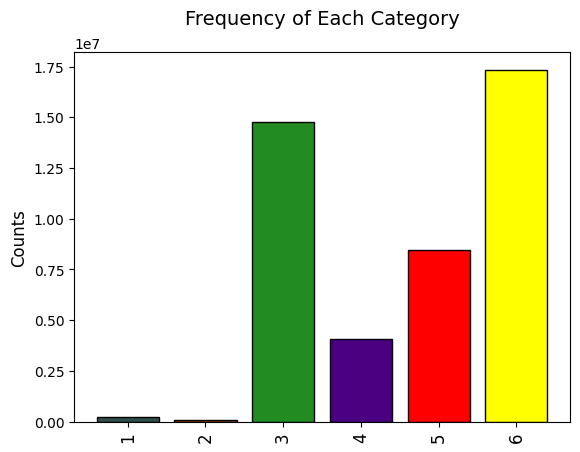

In [ ]:
## RUN this block for the plot
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])
NUM_CLASSES = len(CATEGORIES)
total_train_targets = []
train_dataloader = get_data_loader("data/seg",32, True)
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins,
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Frequency of Each Category', size=14, pad=20);

We observe a significant imbalance in the dataset. Penalizing the network equally for misclassifying categories of varying frequencies wouldn't be logical. If we penalize high-frequency categories the same as low-frequency ones, the model might excel at capturing common patterns but struggle with rare features.

For this reason, we define a few weights for the loss function that correspond to the different classes. These are learnable parameters and we are initializing them manually as per the visualization. You are free to experiment with them as you please.

In [ ]:
alpha = np.ones(6)
alpha[5] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

Initialize the cross entropy loss with the weights and perform the forward pass. Refer to the pytorch documentation on Cross Entropy loss for  more information.

In [ ]:
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        ##########################################

    def forward(self, predictions, targets):
        loss = None
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        ##########################################
        return loss

## Q4c. Training the Network

To train the network the following steps need to be followed:

i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To reduce computation, we are only using 2000 points per point cloud. Slice the data so that you are only using 2000 points.

iii. Compute Forward pass

iv. Calculate the Loss. Here the ```PointNetSegLoss``` is passed as the argument ```criterion``` in the function

v. Perform back propogation and optimize

In [ ]:
def train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion, num_seg_classes = 6):
    model.train()

    step = epoch*len(train_dataloader)
    epoch_loss = 0

    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass

        predictions = None


        ##########################################




        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Initialize & Calculate Loss and perform back propogation

        loss = None


        ##########################################
        epoch_loss += loss

    return epoch_loss

## Q4d. Testing the Network

i. Perform the same steps as Q4c to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Get the prediction with highest probability from the output by using ```torch.softmax```

iv. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints

In [ ]:
def test_segmentation_model(test_dataloader, model, epoch, device):

    model.eval()
    correct_point = 0
    num_point = 0
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################

        # Compute Forward pass and evaluate the model

        predictions = None


        ##########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_point / num_point

    return accuracy

## Running the Model

In [ ]:
NUM_CLASSES = 6
NUM_TRAIN_POINTS = 2000
learning_rate = 0.001
path = "data/seg"
batch_size = 32
num_epochs = 200
model = SegmentationNetwork(NUM_TRAIN_POINTS, NUM_CLASSES)
model_save_path = os.path.join(os. getcwd(), 'model/best_seg_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
opt = optim.Adam(model.parameters(), learning_rate)
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)


alpha = np.ones(6)
alpha[-1] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

criterion = PointNetSegLoss(alpha=alpha).to(device)

model = model.to(device)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion)

    test_accuracy = test_segmentation_model(test_dataloader, model, epoch, device)
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

## Q4e. Inference

i. Visualize a few point clouds that have been segmented correctly. Make sure to use different colours for different classes

ii. Visualize few point clouds that have been segmented incorrectly. Make sure to use different colours for different classes

You can re-use functions defined previously

# Submission Instructions
Run the entire notebook and make sure all outputs are visible. ```We will NOT run your code.```

Rename the notebook as ```uniquename_assignment2.ipynb``` and submit the link of the notebook on canvas. Make sure to set proper access for your link so that anyone with the link can ```view``` your notebook
